In [1]:
#########################################################################
# Video Classification Tutorial - Using CNN + RNN & LSTM
# TensorFlow CPU + Keras 
#########################################################################


# GOAL - To understand the actions within a small video file (3-10 sec) 
# and then make a prediction of this video into various predefined classes. 

# DETAILS: The classes are embeded directly into the file name 
# and folder structure and will be substracted.

# From what I understand, we will first prepare the CNN by downloading 
# the Inceptionv3 pretrained algorithm (in TensorFlow and Keras) 
# and then add our specific video information into the top layer 
# of Inceptionv3 and retrain just that portion of the neural network.

# We will then flatten the results of the CNN and then feed the newly saved 
# features/weights into a Long Short Term Memory(LSTM) Recurrent Neural 
# Network (RNN) for further processing.

# What this code should do would be to take the video and split it into
# individual images via the cv2 package. For ease of use, we grab the nth 
# frame of each video and then feed this into the the CNN.

# I think that the goal will be to seperate this code into at least 2 files
#      1. Training & Testing Procedure
#      2. Application of trained algorithm to new video

# https://www.analyticsvidhya.com/blog/2018/09/deep-learning-video-classification-python/

In [2]:
# Declare Packages

import cv2
import math
import sys
import argparse

print(cv2.__version__)

# Initialize Core Packages

import keras
import numpy as np
import matplotlib.pyplot as plt

import os

# new stuff
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import optimizers
import keras
from keras.optimizers import SGD
from keras.models import load_model
from keras.preprocessing import image

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from skimage import data_dir

# print(tf.__version__)

##### Initialize Core Packages

import keras
import numpy as np
import matplotlib.pyplot as plt

import os

# new stuff
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

import keras
from keras.optimizers import SGD

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

3.4.2


C:\Users\derek\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


1.9.0


In [3]:
# Declare Variables to be used later.

algorithmFolder = "C:/Users/derek/Documents/Python_Scripts/Project_Adam/Model_Training_Routines/Classification/"
Raw_Video_Source = 'C:/Users/derek/Documents/Python_Scripts/Project_Adam/Raw_Video/'
Video_Frame_Destination = 'C:/Users/derek/Documents/Python_Scripts/Project_Adam/Raw_Video_Processed/'
Training_Sample = 0.95 # Original 0.95
 
base_dir = 'C:/Users/derek/Documents/Python_Scripts/Project_Adam/Raw_Video_Processed'

# This frame extract rate will pick up the Nth frame of a video. Typically 25 or 30

frame_extract_rate = 30

# The shape of the individual image is 3 layers of 240 pixels by 320 pixels

horizontal_size = 240
vertical_size = 320
layer_count = 3


batch_size = 1 # Originally 64. 
model_batch_size = 64 #64


label_count = 2 # this is the # of classes

sample_multiple = 1 #This is used for the training procedure. Sample Size * n

Epochs_CNN = 10
Epochs_LSTM = 30

train_data_dir = 'C:/Users/derek/Documents/Python_Scripts/Project_Adam/Raw_Video_Processed/train/'
validation_data_dir = 'C:/Users/derek/Documents/Python_Scripts/Project_Adam/Raw_Video_Processed/test/'
nb_train_samples = 136  #total
nb_validation_samples = 98  # total
epochs = 1
batch_size = 1

# This will place a hard cap of the total number of frames to N within a video clip.

video_frame_count = 80

# This will be a count of the videos for the RNN training

# video_train_count = 10
# video_test_count = 3

In [4]:
# Import the Inception 3 algorithm 

from keras.applications import InceptionV3

In [5]:
# We will re-train the top layer of Inception with our own dataset. Thats why we define include_top to false
# The shape of the individual image is 3 layers of 240 pixels by 320 pixels

conv_base = InceptionV3(weights='imagenet',
                       include_top=False,
                       input_shape=(horizontal_size, vertical_size, layer_count)
                       )

In [6]:
# Review the output parameters for the Inception v3

conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 320, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 119, 159, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 119, 159, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 119, 159, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [7]:
if K.image_data_format() == 'channels_first':
    input_shape = (layer_count, horizontal_size, vertical_size)
else:
    input_shape = (horizontal_size, vertical_size, layer_count)

In [8]:
# Define a function that identifies all of the videos in a directory and creates a proper training and testing split.

def videos2frames(source_dir, target_dir, train_percentage):
    import os
    import re
    
    delete_dir(target_dir)
    create_dir_if_not_exists(target_dir)
    
    data_dirs = (f for f in sorted(os.listdir(source_dir)) if not f.startswith('.'))
                
    for cat_name in data_dirs:
        source_cat_dir = os.path.join(source_dir, cat_name)
        groups = list({re.search('^\w+_\w+_g(\d\d)_c(\d\d)', f).group(1) for f in os.listdir(source_cat_dir) if not f.startswith('.')})
        group_size = len(groups)
        np.random.shuffle(groups)
                 
        x = 0
        y = 0
        
        video_dir = os.path.join(source_dir, cat_name)
        
        video_path = (f for f in os.listdir(video_dir) if not f.startswith('.'))
        for video_file in video_path:
            m = re.search('^\w+_\w+_g(\d\d)_c(\d\d)', video_file)
            group_name = m.group(1)
            subject_name = m.group(2)
                 
            if group_name in groups[:int(group_size * train_percentage)]:
                parent_dir = 'train'
                x += 1
            else:
                parent_dir = 'test'
                y += 1
                 
            src_video_path = os.path.join(video_dir, video_file)
            frames_dir = os.path.join(os.path.join(target_dir, parent_dir),cat_name)
                 
            create_dir_if_not_exists(frames_dir)
            extract_frames_from_video(src_video_path, frames_dir, "{}-{}".format(group_name, subject_name))
                
def create_dir_if_not_exists(path):
    import os
    if not os.path.exists(path):
        os.makedirs(path)
                        
def delete_dir(path):
    import shutil
    import os
                 
    if os.path.exists(path):
        shutil.rmtree(path)

In [9]:
# Define a function that extracts the frames from a video.

def extract_frames_from_video(video_path, target_dir, target_file_prefix):
    import cv2
    
    v = cv2.VideoCapture(video_path)
    
    success, image = v.read()
    count = 0 
    
    while success:
        count += 1
        if count % frame_extract_rate == 0:
            cv2.imwrite('{}/{}-{}.jpg'.format(target_dir, target_file_prefix, count), image)
        success, image = v.read()

In [10]:
# This is the funciton which creates the training/test split and also extracts out individual pictures

videos2frames(Raw_Video_Source, Video_Frame_Destination, Training_Sample) 

In [11]:
# Define the training and validation directories for later.

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

In [12]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

In [13]:
# This function is a count of the total number of features

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 6, 8, 2048))
    labels = np.zeros(shape=(sample_count, label_count)) 
    generator = datagen.flow_from_directory(
        directory,
        target_size=(horizontal_size, vertical_size),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        print(i * batch_size)
        if i * batch_size >= sample_count:
            break
    return features, labels 

#         if i * batch_size >= sample_count:
#             batch_size = sample_count-(i * batch_size)


In [14]:
%%capture output

generator = datagen.flow_from_directory(validation_dir, 
                                        target_size=(horizontal_size, vertical_size), 
                                        batch_size=batch_size, 
                                        class_mode='categorical')

In [15]:
# This pulls out programatically the total number of images to be used at a later time.
prev_cell_output = str(output)

# This finds the nth word of a string
image_number = int(prev_cell_output.split()[1])

In [16]:
# We make the batch size equal
 
batch_size_validate = image_number

In [17]:
# This will run the validation routine and begin to train the features. Sample size is a multiple of the batch

validation_features, validation_labels = extract_features(validation_dir, batch_size_validate*sample_multiple) # Original 237, batch size times 2 ensures no errors.

Found 6 images belonging to 2 classes.
1
2
3
4
5
6


In [18]:
# This will save the validation routine's features and labels.

np.save("validation_features.npy", validation_features)
np.save("validation_labels.npy", validation_labels)

validation_features.shape, validation_labels.shape

((6, 6, 8, 2048), (6, 2))

In [19]:
%%capture output2

generator_train = datagen.flow_from_directory(train_dir, 
                                              target_size=(horizontal_size, vertical_size), 
                                              batch_size=batch_size, 
                                              class_mode='categorical')

In [20]:
# This pulls out programatically the total number of images to be used at a later time.
prev_cell_output2 = str(output2)

# This finds the nth word of a string
image_number2 = int(prev_cell_output2.split()[1])

In [21]:
# This is where we will export the # of images above  to a dynamic value

batch_size_train = image_number2

In [22]:
# This will run the training routine and begin to train the features. Sample size is a multiple of the batch

train_features, train_labels = extract_features(train_dir, batch_size_train*sample_multiple) # Original 3104, batch size times 2 ensures no errors.

Found 152 images belonging to 2 classes.
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152


In [23]:
# This will save the training routine's features and labels.

np.save("train_features.npy", train_features)
np.save("train_labels.npy", train_labels)

train_features.shape, train_labels.shape

((152, 6, 8, 2048), (152, 2))

In [24]:
# Setup of the train features and validation features 

train_features = np.reshape(train_features, (batch_size_train*sample_multiple, 6 * 8 * 2048)) # Original 3104 
validation_features = np.reshape(validation_features, (batch_size_validate*sample_multiple, 6 * 8 * 2048)) # Original 237

# train_features

In [25]:
train_features = train_features.reshape(batch_size_train, 6*8*2048)      # converting to 1-D, 375 is image_number2
validation_features = validation_features.reshape(batch_size_validate, 6*8*2048)

In [26]:
# Create a new simple CNN model and add layers based upon features substracted from existing Inception model

from keras import models
from keras import layers
from keras import optimizers

model = Sequential()

model.add(layers.Dense(256, activation='relu', input_dim=6 * 8 * 2048)) # input_dim=6 * 8 * 2048) input_shape
model.add(layers.Dropout(0.9))
model.add(layers.Dense(label_count, activation='softmax'))


# This is the top layer. Dense 3 represents the 3 classes we are trying to predict.

# model.add(Dense(3)) 
# model.add(Activation('softmax'))

model.compile(optimizer=optimizers.adam(lr=2e-6),
             loss='categorical_crossentropy',
             metrics=['acc'])



In [27]:
history = model.fit(train_features, train_labels,
                   epochs=Epochs_CNN, #Original 10
                   batch_size=model_batch_size, #Original 64
                   validation_data=(validation_features, validation_labels))

Train on 152 samples, validate on 6 samples
Epoch 1/10
152/152 [==============================] - 9s 58ms/step - loss: 2.3283 - acc: 0.4803 - val_loss: 0.6784 - val_acc: 0.8333
Epoch 2/10
152/152 [==============================] - 2s 15ms/step - loss: 2.4521 - acc: 0.4803 - val_loss: 0.7271 - val_acc: 0.6667
Epoch 3/10
152/152 [==============================] - 2s 15ms/step - loss: 1.8736 - acc: 0.4934 - val_loss: 0.7500 - val_acc: 0.6667
Epoch 4/10
152/152 [==============================] - 3s 17ms/step - loss: 2.2752 - acc: 0.4803 - val_loss: 0.7615 - val_acc: 0.6667
Epoch 5/10
152/152 [==============================] - 2s 15ms/step - loss: 1.9904 - acc: 0.4868 - val_loss: 0.7769 - val_acc: 0.6667
Epoch 6/10
152/152 [==============================] - 2s 16ms/step - loss: 1.9650 - acc: 0.5395 - val_loss: 0.7948 - val_acc: 0.6667
Epoch 7/10
152/152 [==============================] - 2s 16ms/step - loss: 1.7282 - acc: 0.4934 - val_loss: 0.7991 - val_acc: 0.6667
Epoch 8/10
152/152 [=====

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25166080  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 25,166,594
Trainable params: 25,166,594
Non-trainable params: 0
_________________________________________________________________


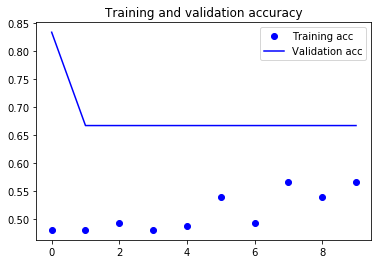

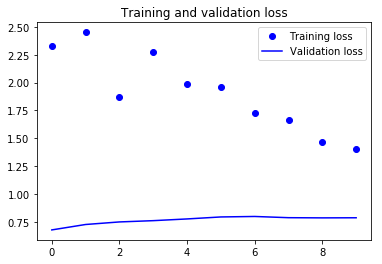

<Figure size 432x288 with 0 Axes>

In [29]:
# Diagnostic plots for the CNN algorithm accuracy

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.show()

In [30]:
# Save the Newly Trained Inception Model

model.save(algorithmFolder + 'modeltestDK.h5')

In [31]:
# Produce a graph of the inception network

# from keras.utils import plot_model
# plot_model(conv_base, show_shapes=True, to_file=algorithmFolder + 'ModelGraphic.png')

In [32]:
###############################################################################################
# Phase II - Extract the dense layer from the first trained network 
# and concatenating that to the Inception v3 CNN as the top layer.
###############################################################################################

In [33]:
from keras import models
from keras import layers

model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(model.layers[0])

In [34]:
# View the output of the final CNN mode that leverages inception 

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 8, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 98304)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25166080  
Total params: 46,968,864
Trainable params: 46,934,432
Non-trainable params: 34,432
_________________________________________________________________


In [35]:
# Save the Newly Trained Inception Model

model.save(algorithmFolder + 'modeltestDKInception.h5')

In [36]:
###############################################################################################
# Phase III - Prepare the RNN and extract features from the Inception model training. 
###############################################################################################

In [37]:
# This is the function which will load the videos from the main directory and prepare them for processing in the RNN/LSTM
# Please note that the model2 (proper connected Inception CNN) is used within this function! 

def extract_features_RNN(cat_dict, dir_path, cat_groups, sample_size):
    import re
    import cv2
    
    s = 0
    
    features = np.zeros(shape=(sample_size, video_frame_count , 256))
    labels = np.zeros(shape=(sample_size, layer_count)) # original 3 label_count
    frames = np.zeros(shape=(video_frame_count, horizontal_size, vertical_size, layer_count)) # original 3
    
    video_path = (f for f in os.listdir(dir_path) if not f.startswith('.'))
    for cat in video_path:
        print(cat, cat_dict[cat])
        cat_dir = os.path.join(dir_path, cat)
        video_files = (f for f in os.listdir(cat_dir) if not f.startswith('.'))
        for f in video_files:
        #for f in sorted(video_files)[1:]:
            if s >= sample_size:
                break
            group_name = re.search('^\w+_\w+_g(\d\d)', f).group(1)
            if group_name in cat_groups[cat]:
                v = cv2.VideoCapture(os.path.join(cat_dir, f))
                frame_count = int(v.get(cv2.CAP_PROP_FRAME_COUNT))
                frame_height = int(v.get(cv2.CAP_PROP_FRAME_HEIGHT))
                frame_width = int(v.get(cv2.CAP_PROP_FRAME_WIDTH))
                if frame_count >= video_frame_count and frame_height == horizontal_size and frame_width == vertical_size:
                    read_frames_idx = list(range(0, frame_count, frame_count))
                    for i, idx in enumerate(read_frames_idx):
                        v.set(cv2.CAP_PROP_POS_FRAMES, idx)
                        success, image = v.read()
                            #print(s, i, idx, success)
                        if success:
                            frames[i] = image / 255.
                        else:
                            print("ERROR")
                    features[s, :, :] = model2.predict(frames)
                    labels[s, cat_dict[cat]] = 1
                    print(s)
                    s += 1
                        
    return s, features, labels

In [38]:
# Find the category group names

def find_cat_groups(dir_name):
    import re
    
    cat_groups = {}
    
    for cat in os.listdir(dir_name):
        samples_dir = os.path.join(dir_name, cat)
        cat_groups[cat] = {re.search('^(\d+)', f).group(1) for f in os.listdir(samples_dir) if not f.startswith('.')}
    
    return cat_groups

In [39]:
# Additional features to review

cat_groups_train, cat_groups_validation = find_cat_groups(train_dir), find_cat_groups(validation_dir)

In [40]:
#Display the catgory of training

cat_groups_train

{'Canter': {'02', '03', '04', '05', '06', '07', '08'},
 'Trot': {'01', '02', '03', '04', '05', '06', '08'}}

In [41]:
# Save the category training # of entries for future use

video_train_count = sum(map(len, cat_groups_train.values()))
# print(video_train_count)

In [42]:
# Display the catgory of validation

cat_groups_validation

{'Canter': {'01'}, 'Trot': {'09'}}

In [43]:
# Save the category testing # of entries for future use

video_test_count= sum(map(len, cat_groups_validation.values()))
#print(video_test_count)

In [44]:
# Ensure that the length of the train and validation are identical

len(cat_groups_train), len(cat_groups_validation)

(2, 2)

In [45]:
# Review the categories in a dictionary that you train

cat_dict = {cat_name: i for i, cat_name in enumerate(cat_groups_train.keys())}

In [46]:
# This is the RNN training procedure
# Note: Remove Hard code from video_train_count and make dynamic


size, features_rnn, labels_rnn = extract_features_RNN(cat_dict, Raw_Video_Source, cat_groups_train, video_train_count) # original 3104

Canter 0
Trot 1


In [47]:
# Save the various features for the RNN training

np.save("features_rnn", features_rnn[:size,:,:])
np.save("labels_rnn", labels_rnn[:size,:])
size

0

In [48]:
# This is the RNN validation procedure

size_v, features_rnn_v, labels_rnn_v = extract_features_RNN(cat_dict, Raw_Video_Source, cat_groups_validation, video_test_count) #original is 237

Canter 0
Trot 1


In [49]:
# Save the various features for the RNN training

np.save("features_rnn_v.np", features_rnn_v[:size_v,:,:])
np.save("labels_rnn_v.np", labels_rnn_v[:size_v,:])

In [50]:
# Describe the various features

features_rnn.shape, labels_rnn.shape

((14, 80, 256), (14, 3))

In [51]:
# Describe the RNN various features for the validation

features_rnn_v.shape, labels_rnn_v.shape

((2, 80, 256), (2, 3))

In [52]:
# This finds the first value of a tuple

Dense_Function = labels_rnn_v.shape[1]

In [53]:
###############################################################################################
# Phase IV - Build the LSTM algorithm and pass the RNN features as the parameters 
###############################################################################################

In [54]:
# Build the Long Short Term Memory Algorithm (LSTM)

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(200, input_shape=(video_frame_count, 256)))
model.add(Dense(Dense_Function, activation='softmax')) # Original 3

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['acc'])

In [55]:
# Fit the LSTM model

hist = model.fit(features_rnn, labels_rnn,
                epochs=Epochs_LSTM, # 30 in the original
                batch_size=1,
                validation_data=(features_rnn_v, labels_rnn_v))

Train on 14 samples, validate on 2 samples
Epoch 1/30
14/14 [==============================] - 8s 599ms/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/30
14/14 [==============================] - 1s 103ms/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/30
14/14 [==============================] - 2s 122ms/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/30
14/14 [==============================] - 2s 138ms/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/30
14/14 [==============================] - 1s 104ms/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/30
14/14 [==============================] - 1s 100ms/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/30
14/14 [==============================] - 2s 110ms/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000

In [56]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               365600    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 603       
Total params: 366,203
Trainable params: 366,203
Non-trainable params: 0
_________________________________________________________________


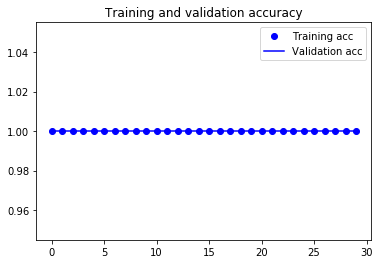

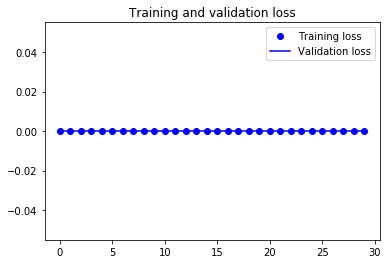

<Figure size 432x288 with 0 Axes>

In [57]:
# Diagnostic plots for the CNN algorithm accuracy

acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.show()

In [58]:
# Save the Fully Trained LSTM model

model.save(algorithmFolder + 'modeltestDKLSTM.h5')